In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import os,sys
opj = os.path.join
from copy import deepcopy
import pickle as pkl
import pandas as pd
import random

sys.path.append('../../src')
sys.path.append('../../src/dsets/cosmology')
from dset import get_dataloader
from viz import viz_im_r, cshow, viz_filters
from sim_cosmology import p, load_dataloader_and_pretrained_model
from losses import get_loss_f
from train import Trainer, Validator

# wt modules
from wavelet_transform import Wavelet_Transform, Attributer, get_2dfilts, initialize_filters
from utils import tuple_L1Loss, tuple_L2Loss, thresh_attrs, viz_list

# load results

In [2]:
dirs = ["vary_lamL1attr_seeds_initialized"]
results = []
models = []
for i in range(len(dirs)):
    # load results
    out_dir = opj("/home/ubuntu/local-vae/notebooks/ex_cosmology/results", dirs[i])
    fnames = sorted(os.listdir(out_dir))
    
    results_list = []
    models_list = []
    for fname in fnames:
        if fname[-3:] == 'pkl':
            results_list.append(pkl.load(open(opj(out_dir, fname), 'rb')))
        if fname[-3:] == 'pth':
            wt = Wavelet_Transform(wt_type='DWT', wave='db3', mode='symmetric', device='cuda', J=5)
            wt.load_state_dict(torch.load(opj(out_dir, fname)))
            models_list.append(wt)
    results.append(pd.DataFrame(results_list))
    models.append(models_list)

## load data and model

In [3]:
# get dataloader and model
(train_loader, test_loader), model = load_dataloader_and_pretrained_model(p, img_size=256)
torch.manual_seed(p.seed)
im = iter(test_loader).next()[0][0:64].to(device)

## initialize filter

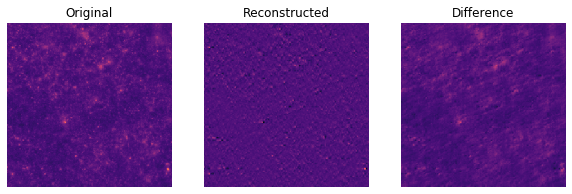

Recon=11.99814


In [125]:
# wavelet transform with initialization
wt_orig = Wavelet_Transform(wt_type='DWT', wave='db3', mode='symmetric', device='cuda', J=5)
seed = 100
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
wt = initialize_filters(wt_orig, init_level=1, noise_level=0.1)
filt = get_2dfilts(wt)
viz_im_r(im[0], wt.inverse(wt(im))[0])
print("Recon={:.5f}".format(torch.norm(wt.inverse(wt(im)) - im)**2/im.size(0)))

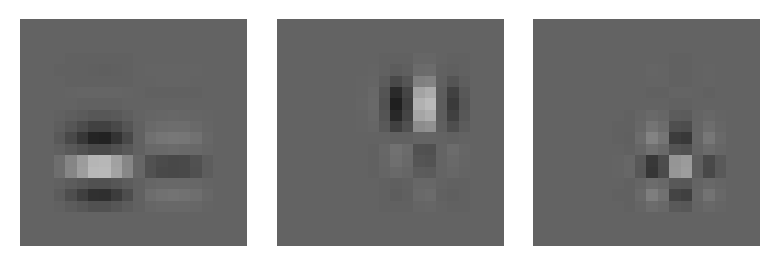

In [9]:
viz_list(filt, figsize=(4,4))

# Plotting

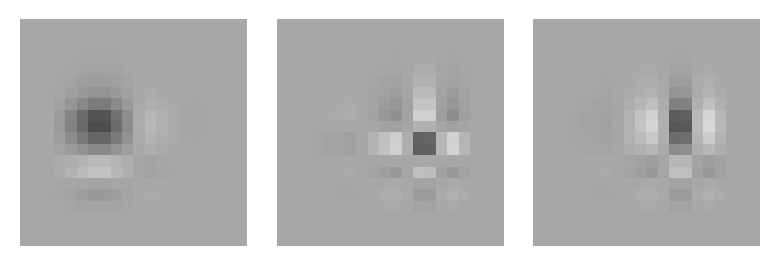

In [16]:
index = 18
wt = models[0][index]
res = results[0]
filt = get_2dfilts(wt)
viz_list(filt, figsize=(4,4))

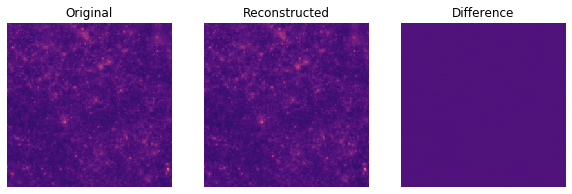

Recon=0.00000


In [17]:
viz_im_r(im[0], wt.inverse(wt(im))[0])
print("Recon={:.5f}".format(torch.norm(wt.inverse(wt(im)) - im)**2/im.size(0)))

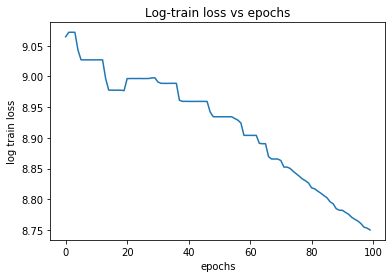

In [18]:
plt.plot(np.log(res['train_losses'][index]))
plt.xlabel("epochs")
plt.ylabel("log train loss")
plt.title('Log-train loss vs epochs')
plt.show()

In [19]:
lamb_seq = np.round(np.geomspace(1, 100, 20), 5)
print('Original filter: Test recon-error={:.6f} Test L1-penalty={:.6f}'.format(0, 93.83803))
for i in range(len(models[0])):
    print('Lambda={:.6f} Test recon-error={:.6f} Test L1-penalty={:.6f}'.format(lamb_seq[i], res['val_rec_loss'][i], res['val_L1attr_loss'][i]))


Original filter: Test recon-error=0.000000 Test L1-penalty=93.838030
Lambda=1.000000 Test recon-error=0.000001 Test L1-penalty=84.494770
Lambda=1.274270 Test recon-error=0.000000 Test L1-penalty=88.696285
Lambda=1.623780 Test recon-error=0.000000 Test L1-penalty=117.693804
Lambda=2.069140 Test recon-error=0.004599 Test L1-penalty=106.930228
Lambda=2.636650 Test recon-error=0.000001 Test L1-penalty=95.068963
Lambda=3.359820 Test recon-error=0.000155 Test L1-penalty=110.960504
Lambda=4.281330 Test recon-error=0.000018 Test L1-penalty=92.154289
Lambda=5.455590 Test recon-error=0.000000 Test L1-penalty=95.003176
Lambda=6.951930 Test recon-error=0.000000 Test L1-penalty=85.157819
Lambda=8.858670 Test recon-error=0.000000 Test L1-penalty=110.111147
Lambda=11.288380 Test recon-error=0.000027 Test L1-penalty=103.251429
Lambda=14.384500 Test recon-error=0.000100 Test L1-penalty=96.560016
Lambda=18.329810 Test recon-error=0.000000 Test L1-penalty=103.582368
Lambda=23.357210 Test recon-error=0.00

In [161]:
import pywt
wave = pywt.Wavelet('db4')
phi, psi, x = wave.wavefun(level=4)

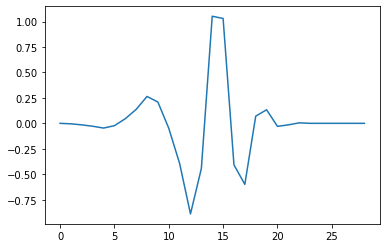

In [157]:
plt.plot(psi)


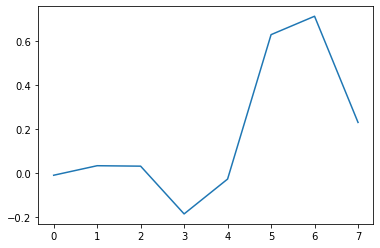

In [145]:
plt.plot(wave.dec_lo)

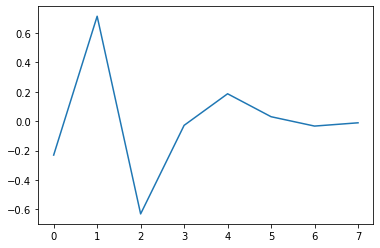

In [146]:
plt.plot(wave.dec_hi)

In [147]:
wt_orig = Wavelet_Transform(wt_type='DWT', wave='db4', mode='symmetric', device='cuda', J=5)

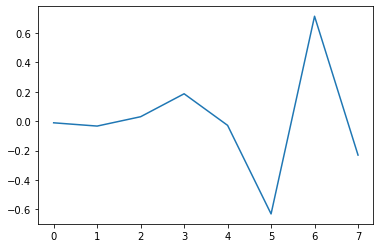

In [148]:
plt.plot(wt_orig.xfm.h1_row.data.detach().cpu().numpy().reshape(-1))

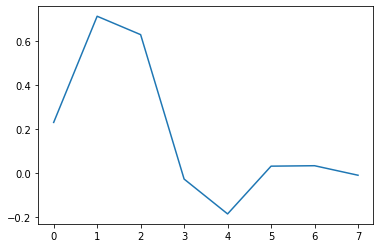

In [149]:
plt.plot(wt_orig.ifm.g0_row.data.detach().cpu().numpy().reshape(-1))

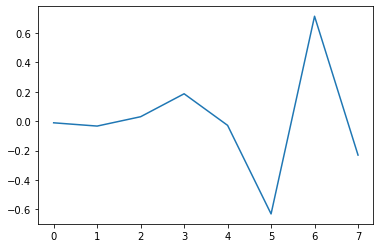

In [129]:
plt.plot(wt_orig.xfm.h1_col.data.detach().cpu().numpy().reshape(-1))

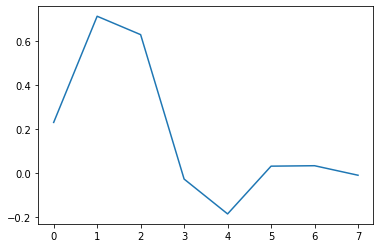

In [132]:
plt.plot(wt_orig.xfm.h0_row.data.detach().cpu().numpy().reshape(-1))

In [63]:
sys.path.append('../../lib/trim')
from trim import TrimModel
mt = TrimModel(model, wt.inverse, use_residuals=True)  
attributer = Attributer(mt, attr_methods='Saliency', device=device)
im = im.to(device)
im_t = wt(im)
attributions = attributer(im_t, target=1, additional_forward_args=deepcopy(im))

mt_orig = TrimModel(model, wt_orig.inverse, use_residuals=True)  
attributer_orig = Attributer(mt_orig, attr_methods='Saliency', device=device)
im = im.to(device)
im_t_orig = wt_orig(im)
attributions_orig = attributer_orig(im_t_orig, target=1, additional_forward_args=deepcopy(im))

In [93]:
J = len(im_t)
vmax = -1e5
vmin = 1e5
for i in range(J):
    max1 = torch.max(attributions[i].detach().cpu())
    max2 = torch.max(attributions_orig[i].detach().cpu())
    min1 = torch.min(attributions[i].detach().cpu())
    min2 = torch.min(attributions_orig[i].detach().cpu())    
    maxx = max(max1, max2)
    vmax = max(maxx, vmax)
    minn = min(min1, min2)
    vmin = min(minn, vmin)
    

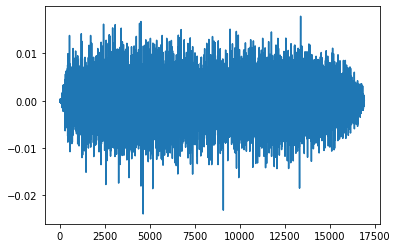

In [103]:
plt.plot(attributions[1][0,0,1].detach().cpu().reshape(-1).numpy())

In [114]:
np.sum(abs(attributions[1][0,0,1].detach().cpu().reshape(-1).numpy()) < 1e-2)

16563

In [115]:
np.sum(abs(attributions_orig[1][0,0,1].detach().cpu().reshape(-1).numpy()) < 1e-2)

16487

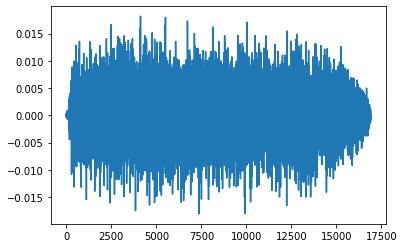

In [104]:
plt.plot(attributions_orig[1][0,0,1].detach().cpu().reshape(-1).numpy())

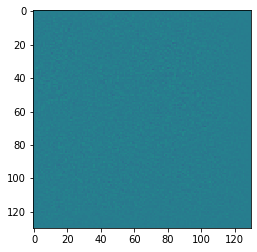

In [96]:
plt.imshow(attributions[1][0,0,1].detach().cpu(), vmax=vmax, vmin=vmin)

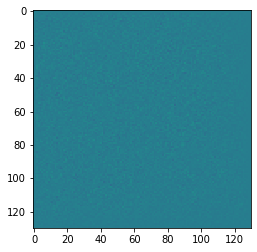

In [97]:
plt.imshow(attributions_orig[1][0,0,1].detach().cpu(), vmax=vmax, vmin=vmin)